# Importing Libraries


import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import Callback,EarlyStopping, ModelCheckpoint


# Load and Visualizing Datasets

In [2]:
path = 'data/'
path_all = list(glob.glob(path+'**/*jpg'))
path_Negative = path + 'Negative/*.jpg'
path_Positive = path + 'Positive/*.jpg'

Text(0.5, 1.0, 'Negative and Positive')

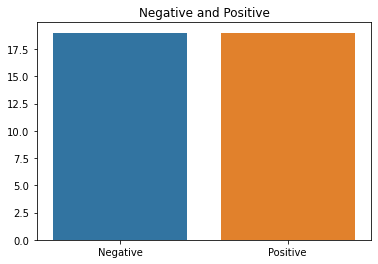

In [3]:
sns.barplot(x=['Negative','Positive'], y=[len(path_Negative), len(path_Positive)])
plt.title('Negative and Positive')

In [4]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_all))
file_Path = pd.Series(path_all, name='File_Path').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([file_Path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Label
0,data\Positive\13101_1.jpg,Positive
1,data\Positive\12452_1.jpg,Positive
2,data\Positive\00507.jpg,Positive
3,data\Positive\14545_1.jpg,Positive
4,data\Negative\14660.jpg,Negative


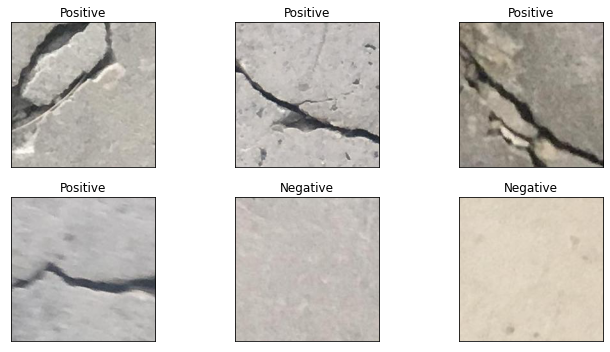

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [ ]:
#initialize random seeds so results are repeatable
import random
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [6]:
train_df, test_df = train_test_split(data, test_size=0.3, random_state=42)


# Functions

In [7]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(
                        preprocessing_function=pre,
                        validation_split=0.3)
    test_datagen = ImageDataGenerator(
                        preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=64,
        shuffle=True,
        seed=42
        )

    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=False
    )
    return train_gen, test_gen

In [8]:
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),alpha=1.0,
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = True
    inputs = pre_model.input

    x = Dense(64, activation='relu')(pre_model.output)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [ModelCheckpoint('model1-{epoch:03d}.h5',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')]
    return model, my_callbacks



In [9]:
def plot(history,df_test,test_gen,train_gen):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
        
    # Predict Data Test
    
    ## load best model (after training) to see confusion matrix
    
    #model=load_model(r"/content/gdrive/MyDrive/surfacedata/model1-008.h5")
    
    ##
    
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    cm=confusion_matrix(df_test.Label,pred)
    clr = classification_report(df_test.Label, pred, target_names=["NEGATIVE", "POSITIVE"])
    print(clr)
    print(cm)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df_test.File_Path.iloc[i+1]))
        ax.set_title(f"True: {df_test.Label.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
        
    return history,cm

In [10]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

In [13]:
from tensorflow.keras.applications import VGG16,MobileNetV2, DenseNet121,NASNetMobile, MobileNetV3Small,VGG19
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

net_pre=preprocess_input
train_gen_net ,test_gen_net = gen(net_pre,train_df,test_df)

Found 28000 validated image filenames belonging to 2 classes.
Found 12000 validated image filenames belonging to 2 classes.


In [ ]:
model, callback=func(MobileNetV2)

# Training

In [ ]:
history = model.fit(
    train_gen_net,
    validation_data=test_gen_net ,
    epochs=10,
    callbacks=callback
)

# Plot results

In [ ]:
#before run this cell, choose the best model in plot function that commented.
history,cm=plot(history,test_df,test_gen_net,train_gen_net)

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

conf_matrix = cm
binary1 = conf_matrix 

fig, ax = plot_confusion_matrix(conf_mat=binary1,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                )
plt.title('Confusion matrix (for Test data)')
plt.show()

In [ ]:
#load the best model to see results
from keras.models import load_model
model=load_model(r"/content/gdrive/MyDrive/surfacedata/model1-008.h5")

In [ ]:
result_myNet = result_test(test_gen_net,model)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools


def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()


def main():

    sampleClassificationReport = """             precision    recall  f1-score   support

          NEGATIVE       1.00      1.00      1.00       5977
          POSITIVE       1.00      1.00      1.00       6023

        acc       1.00      1.00      1.00       12000"""

    plot_classification_report(sampleClassificationReport)
    plt.show()
    plt.close()


if __name__ == '__main__':
    main()
